Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

Import Datasets into DataFrames

In [2]:
econ_freedom = pd.read_csv("economic_freedom_index2019_data.csv",encoding='latin-1', index_col = "Country")
gender_development = pd.read_csv("gender_development.csv",index_col = "Country")
gender_inequality = pd.read_csv("gender_inequality.csv",index_col = "Country")
historical_index = pd.read_csv("historical_index.csv",index_col = "Country")
human_development = pd.read_csv("human_development.csv",index_col = "Country")
inequality = pd.read_csv("inequality_adjusted.csv",index_col = "Country")
poverty = pd.read_csv("multidimensional_poverty.csv",index_col = "Country")


FileNotFoundError: [Errno 2] No such file or directory: 'economic_freedom_index2019_data.csv'

Helper Functions Utilized

In [31]:
def UpdateCountry(df, old, new):
    df.loc[new] = historical_index.loc[old].values
    df = df.drop(old)
    return df

def make_map(df, metrics):
    traces=[]

    for metric in metrics:
        traces.append(go.Choropleth(locations=df['Country'].tolist(),
                                    locationmode='country names',
                                    z=df[metric],
                                    colorscale='Portland',
                                    marker_line_color='darkgray',
                                    marker_line_width=0.5,
                                    #text= df.Country.tolist(),
                                    reversescale=True,
                                    colorbar = {'title':metric, 'len':200,'lenmode':'pixels'},
                                    visible=True if metric==metrics[0] else False)
                     )

    updatemenus = []

    buttons=[]
    for metric in metrics:
        # May also need colorbox title?
        buttons.append(dict(method='update',
                            label=metric,
                            args=[{'visible': metrics==metric}])
                      )

    dropdown = dict(buttons=buttons, direction='down',x = 0.01,xanchor = 'left',
                    y = 0.99,yanchor = 'bottom',font = dict(size=11))
    updatemenus=[dropdown] # If we want multiple dropdowns, add em to the list!
    layout = dict(updatemenus=updatemenus,
                  title='Economic and Social Freedoms')

    col_map = go.Figure(data = traces,layout = layout)
    iplot(col_map)

def regional_ttest(df, metrics):
    regions = df.Region.unique()
    regions_short = ['Asia-Pac', 'Eur', 'ME & NA', 'Sub-Shra', 'Americas']
    scores = {}
    for col in metrics:
        scores_col = {}
        for i in range(len(regions)-1):
            for j in range(i+1,len(regions)):
                p = stats.ttest_ind(df.loc[df.Region==regions[i],col].dropna(),
                                    df.loc[df.Region==regions[j],col].dropna())[1]
                scores_col[regions_short[i]+' - '+regions_short[j]] = p
        scores[col] = scores_col
    return scores


Reconcile Country Names

In [32]:
historical_index = UpdateCountry(historical_index,"Hong Kong, China (SAR)","Hong Kong SAR")
historical_index = UpdateCountry(historical_index,"Viet Nam","Vietnam")
historical_index = UpdateCountry(historical_index,"Congo","Congo, Democratic Republic of the Congo")
historical_index = UpdateCountry(historical_index,"Kyrgyzstan","Kyrgyz Republic")
historical_index = UpdateCountry(historical_index,"Lao People's Democratic Republic","Lao P.D.R.")
historical_index = UpdateCountry(historical_index,"Moldova (Republic of)","Moldova")
historical_index = UpdateCountry(historical_index,"Russian Federation","Russia")
historical_index = UpdateCountry(historical_index,"Slovakia","Slovak Republic")
historical_index = UpdateCountry(historical_index,"Tanzania (United Republic of)","Tanzania")
historical_index = UpdateCountry(historical_index,"Venezuela (Bolivarian Republic of)","Venezuela") 
historical_index = UpdateCountry(historical_index,"Bolivia (Plurinational State of)","Bolivia") 


Merge all Data Frames

In [33]:
df_all = human_development.merge(gender_development,on='Country', how = 'inner', suffixes=['_hdi','_gdev'], )
df_all = df_all.merge(gender_inequality, on='Country', how = 'inner', suffixes=['','_gineq'])
df_all = df_all.merge(econ_freedom, on = 'Country', how = 'inner',suffixes=['','_econ'])
df_all = df_all.merge(historical_index, on = 'Country', how = 'inner')

In [34]:
df_all = df_all.rename(columns = {"Human Development Index (1990)":"1990","Human Development Index (2000)":"2000","Human Development Index (2010)":"2010",
                            "Human Development Index (2011)":"2011","Human Development Index (2012)":"2012","Human Development Index (2013)":"2013","Human Development Index (2014)":"2014"})

df_all.replace('..',np.nan,inplace=True)
df_all.replace(',','', regex=True, inplace=True)
df_all.replace('\$','', regex=True, inplace=True)
df_all.replace('40.0 (2015 est.)', '40.0', inplace=True)
df_all.replace('6.1 CHF (2014 )', '6.1', inplace=True)
df_all.replace('2.1 (2016)', '2.1', inplace=True)
df_all.replace('38000 ppl.', '38000', inplace=True)
df_all.replace('139100 (2009 est.)', '139100', inplace=True)
df_all.replace('1700 (2015 est.)','1700', inplace=True)
df_all=df_all.astype({'Population (Millions)': 'float64','GDP (Billions, PPP)': 'float64',
              'GDP per Capita (PPP)': 'float64','Unemployment (%)': 'float64',
              'FDI Inflow (Millions)': 'float64', 'Gender Development Index (GDI)': 'float64',
              '1990':'float64', '2014':'float64'})
df_all.rename(columns={'Country_x':'Country'}, inplace=True)
df_all.rename(columns={"Gov't Spending": "Govt spending", "Gov't Expenditure % of GDP ": "Govt Expenditure % of GDP"}, inplace=True)



What factors affects HDI Growth?

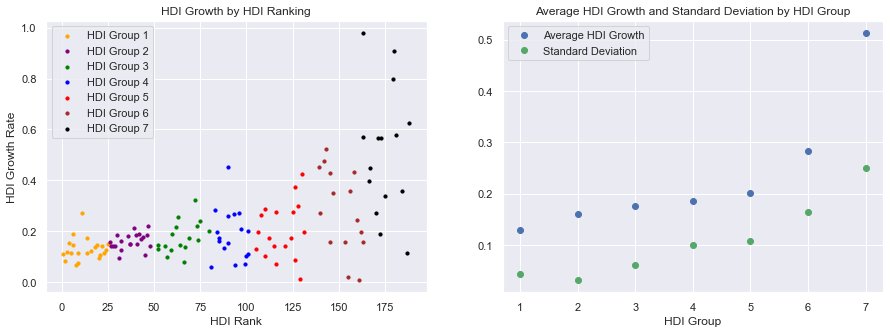

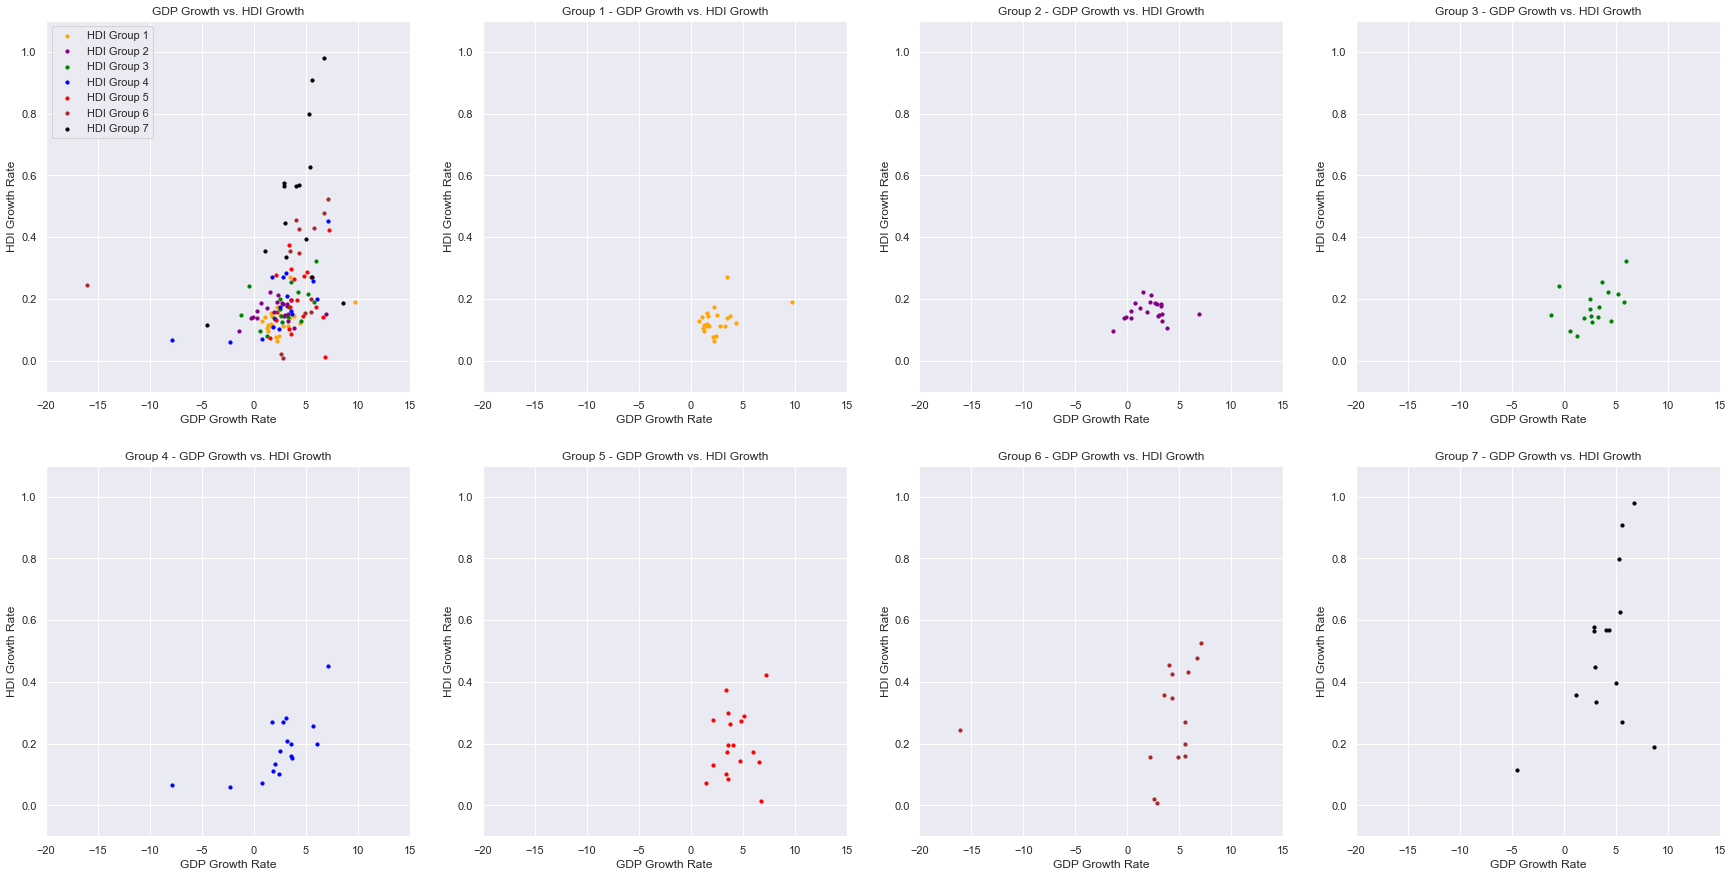

In [35]:
#remove rows with missing required data
df_all = df_all[(df_all["2014"] != 0) & (df_all["1990"] != 0)]

#calculate percent change
df_all["Percent_Change"] = (df_all["2014"] - df_all["1990"])/df_all["1990"]  

#Split up counties into groups based on HDI rank
total_size = df_all["HDI Rank_x"].count()
split_size = math.floor(total_size/7)
econ_vs_hdi_ordered = df_all.sort_values("HDI Rank_x")
econ_vs_hdi_1 = econ_vs_hdi_ordered.head(split_size)
econ_vs_hdi_2 = econ_vs_hdi_ordered.tail(total_size-1*split_size).head(split_size)
econ_vs_hdi_3 = econ_vs_hdi_ordered.tail(total_size-2*split_size).head(split_size)
econ_vs_hdi_4 = econ_vs_hdi_ordered.tail(total_size-3*split_size).head(split_size)
econ_vs_hdi_5 = econ_vs_hdi_ordered.tail(total_size-4*split_size).head(split_size)
econ_vs_hdi_6 = econ_vs_hdi_ordered.tail(total_size-5*split_size).head(split_size)
econ_vs_hdi_7 = econ_vs_hdi_ordered.tail(total_size-6*split_size)

#Plot GDP Growth vs. HDI Growth
ttl1 = "HDI Group 1"
ttl2 = "HDI Group 2"
ttl3 = "HDI Group 3"
ttl4 = "HDI Group 4"
ttl5 = "HDI Group 5"
ttl6 = "HDI Group 6"
ttl7 = "HDI Group 7"

fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.scatter(econ_vs_hdi_1["HDI Rank_x"],econ_vs_hdi_1["Percent_Change"], color = 'orange',s = 10,label = ttl1)
plt.scatter(econ_vs_hdi_2["HDI Rank_x"],econ_vs_hdi_2["Percent_Change"], color = 'purple',s = 10, label = ttl2)
plt.scatter(econ_vs_hdi_3["HDI Rank_x"],econ_vs_hdi_3["Percent_Change"], color = 'green',s = 10,label = ttl3)
plt.scatter(econ_vs_hdi_4["HDI Rank_x"],econ_vs_hdi_4["Percent_Change"], color = 'blue',s = 10,label = ttl4)
plt.scatter(econ_vs_hdi_5["HDI Rank_x"],econ_vs_hdi_5["Percent_Change"], color = 'red',s = 10,label = ttl5)
plt.scatter(econ_vs_hdi_6["HDI Rank_x"],econ_vs_hdi_6["Percent_Change"], color = 'brown',s = 10,label = ttl6)
plt.scatter(econ_vs_hdi_7["HDI Rank_x"],econ_vs_hdi_7["Percent_Change"], color = 'black',s = 10,label = ttl7)
plt.legend(loc = 'upper left')
plt.xlabel("HDI Rank")
plt.ylabel("HDI Growth Rate")
plt.title("HDI Growth by HDI Ranking")


x_titles = [1,2,3,4,5,6,7]

means_hdi = [econ_vs_hdi_1["Percent_Change"].mean(),
             econ_vs_hdi_2["Percent_Change"].mean(),
             econ_vs_hdi_3["Percent_Change"].mean(),
             econ_vs_hdi_4["Percent_Change"].mean(),
             econ_vs_hdi_5["Percent_Change"].mean(),
             econ_vs_hdi_6["Percent_Change"].mean(),
             econ_vs_hdi_7["Percent_Change"].mean()]

std_hdi = [econ_vs_hdi_1["Percent_Change"].std(),
           econ_vs_hdi_2["Percent_Change"].std(),
           econ_vs_hdi_3["Percent_Change"].std(),
           econ_vs_hdi_4["Percent_Change"].std(),
           econ_vs_hdi_5["Percent_Change"].std(),
           econ_vs_hdi_6["Percent_Change"].std(),
           econ_vs_hdi_7["Percent_Change"].std()]


plt.subplot(1,2,2)
plt.plot(x_titles,means_hdi,'bo',label = "Average HDI Growth")
plt.plot(x_titles, std_hdi, 'go',label = "Standard Deviation")
plt.xlabel("HDI Group")
plt.title("Average HDI Growth and Standard Deviation by HDI Group")
plt.legend(loc = 'upper left')


fig = plt.figure(figsize=(30, 15))

gdp_growth_columnn = "5 Year GDP Growth Rate (%)"
hdi_growth_column = "Percent_Change"

plt.subplot(2,4,1)
plt.scatter(econ_vs_hdi_1[gdp_growth_columnn],econ_vs_hdi_1[hdi_growth_column], color = 'orange',s = 10,label = ttl1)
plt.scatter(econ_vs_hdi_2[gdp_growth_columnn],econ_vs_hdi_2[hdi_growth_column], color = 'purple',s = 10, label = ttl2)
plt.scatter(econ_vs_hdi_3[gdp_growth_columnn],econ_vs_hdi_3[hdi_growth_column], color = 'green',s = 10,label = ttl3)
plt.scatter(econ_vs_hdi_4[gdp_growth_columnn],econ_vs_hdi_4[hdi_growth_column], color = 'blue',s = 10,label = ttl4)
plt.scatter(econ_vs_hdi_5[gdp_growth_columnn],econ_vs_hdi_5[hdi_growth_column], color = 'red',s = 10,label = ttl5)
plt.scatter(econ_vs_hdi_6[gdp_growth_columnn],econ_vs_hdi_6[hdi_growth_column], color = 'brown',s = 10,label = ttl6)
plt.scatter(econ_vs_hdi_7[gdp_growth_columnn],econ_vs_hdi_7[hdi_growth_column], color = 'black',s = 10,label = ttl7)
plt.legend(loc = 'upper left')
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.title("GDP Growth vs. HDI Growth")
plt.axis((-20,15,-0.1,1.1))

plt.subplot(2,4,2)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 1 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_1[gdp_growth_columnn],econ_vs_hdi_1[hdi_growth_column], color = 'orange',s = 10,label = ttl1)

plt.subplot(2,4,3)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 2 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_2[gdp_growth_columnn],econ_vs_hdi_2[hdi_growth_column], color = 'purple',s = 10, label = ttl2)

plt.subplot(2,4,4)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 3 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_3[gdp_growth_columnn],econ_vs_hdi_3[hdi_growth_column], color = 'green',s = 10,label = ttl3)

plt.subplot(2,4,5)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 4 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_4[gdp_growth_columnn],econ_vs_hdi_4[hdi_growth_column], color = 'blue',s = 10,label = ttl4)

plt.subplot(2,4,6)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 5 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_5[gdp_growth_columnn],econ_vs_hdi_5[hdi_growth_column], color = 'red',s = 10,label = ttl5)

plt.subplot(2,4,7)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 6 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_6[gdp_growth_columnn],econ_vs_hdi_6[hdi_growth_column], color = 'brown',s = 10,label = ttl6)

plt.subplot(2,4,8)
plt.axis((-20,15,-0.1,1.1))
plt.title("Group 7 - GDP Growth vs. HDI Growth")
plt.xlabel("GDP Growth Rate")
plt.ylabel("HDI Growth Rate")
plt.scatter(econ_vs_hdi_7[gdp_growth_columnn],econ_vs_hdi_7[hdi_growth_column], color = 'black',s = 10,label = ttl7)
plt.savefig("figure2.png")





Recession Analysis

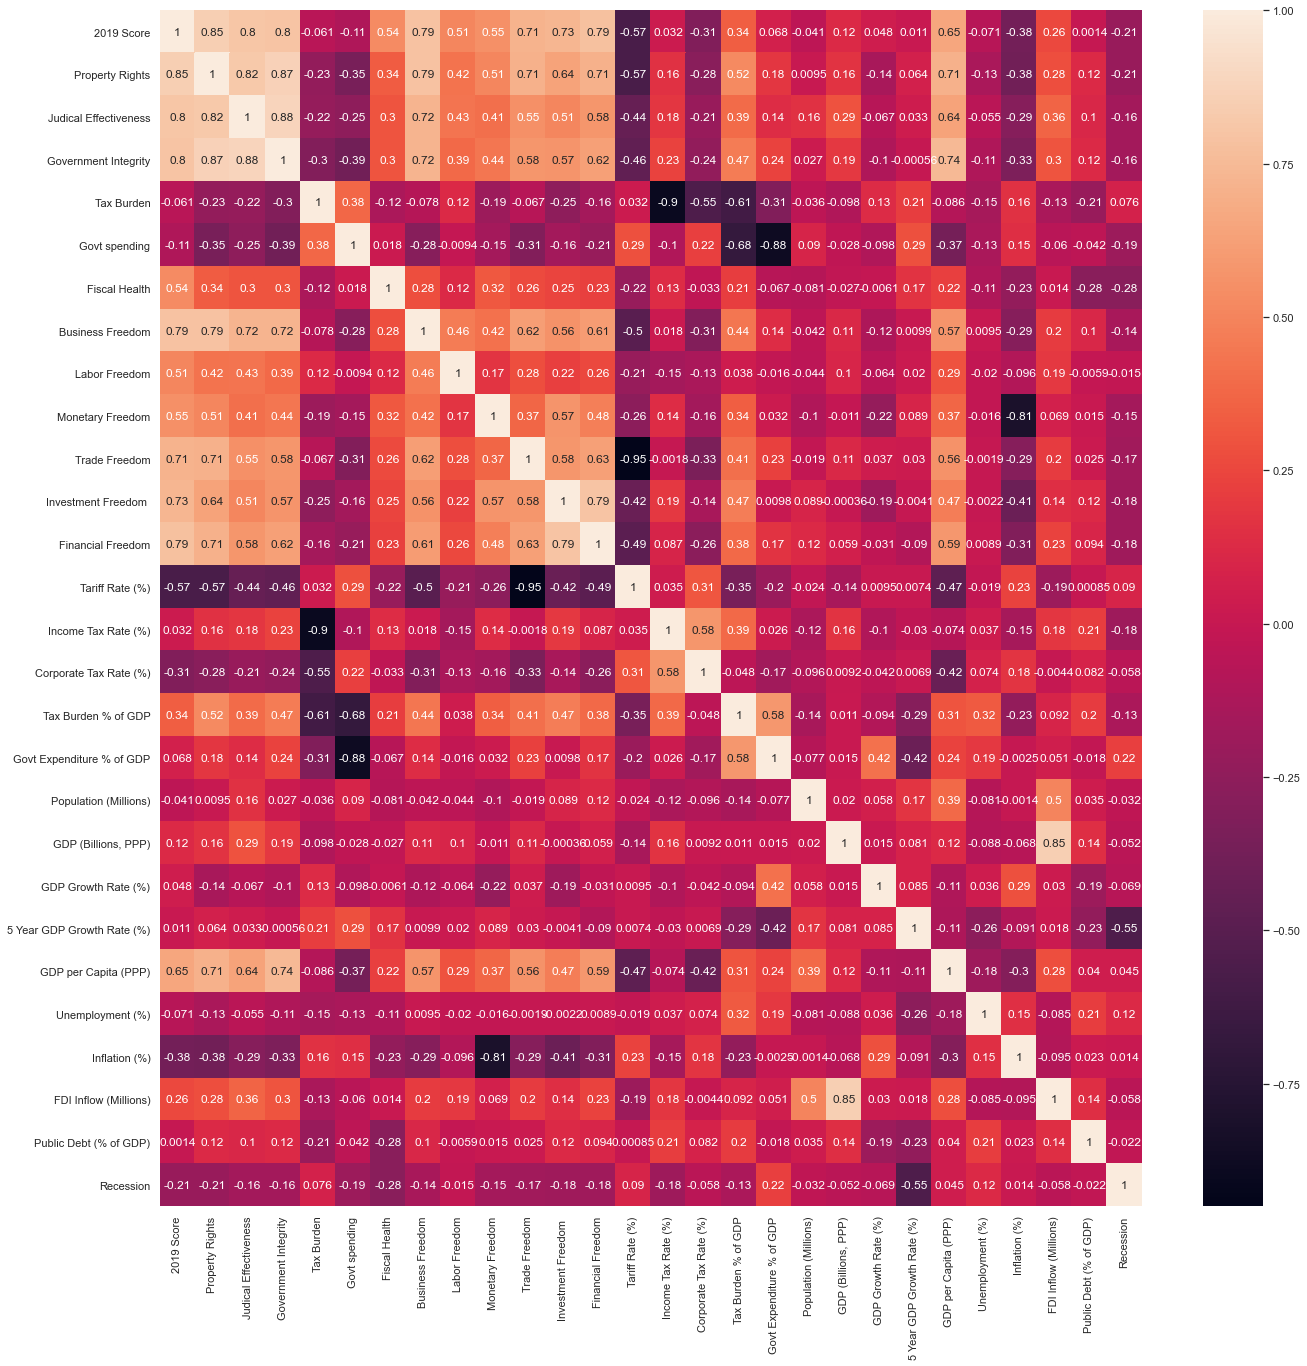

In [36]:
df_all["Recession"] = np.where(((df_all['GDP Growth Rate (%)'] < 0) | (df_all['5 Year GDP Growth Rate (%)'] < 0)), 1 ,0)
df_heat = df_all[["2019 Score",
                 "Property Rights",
                 "Judical Effectiveness",
                 "Government Integrity",
                 "Tax Burden",
                 "Govt spending",
                 "Fiscal Health",
                 "Business Freedom",
                 "Labor Freedom",
                 "Monetary Freedom",
                 "Trade Freedom",
                 "Investment Freedom ",
                 "Financial Freedom",
                 "Tariff Rate (%)",
                 "Income Tax Rate (%)",
                 "Corporate Tax Rate (%)",
                 "Tax Burden % of GDP",
                 "Govt Expenditure % of GDP",
                 "Population (Millions)",
                 "GDP (Billions, PPP)",
                 "GDP Growth Rate (%)",
                 "5 Year GDP Growth Rate (%)",
                 "GDP per Capita (PPP)",
                 "Unemployment (%)",
                 "Inflation (%)",
                 "FDI Inflow (Millions)",
                 "Public Debt (% of GDP)",
                 "Recession"]]

sns.set(rc={'figure.figsize':(22,22)})
sns.heatmap(df_heat.corr(), annot = True)

Recession Analysis Key Finding: High public debt does not amount to Economic Recession. Let us have a look at countries with high public debt as percentage of GDP to confirm what we see in the correlation heat map.


In [37]:
d1=df_all.nlargest(20,['Public Debt (% of GDP)'])[['Country Name' ,'Public Debt (% of GDP)']]
d2=df_all.nlargest(20,['GDP (Billions, PPP)'])[['Country Name' ,'Public Debt (% of GDP)']]
pd.merge(d1, d2, how='inner')


,Country Name,Public Debt (% of GDP)
0,Japan,236.4
1,Italy,131.5
2,United States,107.8
3,Egypt,103.3


Recession Analysis Key Finding: We observe that most of these nations with high debt are developed nations (High GDP per Capita). Hence we confirm that High Public Debt does not amount to recession

In [38]:
d1=df_all.nlargest(20,['Public Debt (% of GDP)'])[['Country Name' ,'Public Debt (% of GDP)']]
d2=df_all.nlargest(20,['GDP per Capita (PPP)'])[['Country Name' ,'GDP per Capita (PPP)']]
pd.merge(d1, d2, how='inner')


,Country Name,Public Debt (% of GDP),GDP per Capita (PPP)
0,Singapore,110.9,93906.0
1,United States,107.8,59501.0


How Economic World Rank and Mean Years Education related? - Farris please take a look

In [39]:
traces=[]
metrics = np.array(['World Rank','Mean Years of Education'])
booly = [True,False]

for metric,i in zip(metrics , range(len(metrics))):
    traces.append(go.Choropleth(locations=df_all.index.tolist(),
                                locationmode='country names',
                                z=df_all[metric],
                                colorscale='Portland',
                                marker_line_color='darkgray',
                                marker_line_width=0.5,
                                text= df_all.index.tolist(),
                                reversescale=booly[i],
                                colorbar = {'title':metric, 'len':500,'lenmode':'pixels' },
                                visible=True if metric== 'World Rank' else False) )
    
updatemenus = []
buttons=[]
for metric in metrics:
    buttons.append(dict(method='update',
                        label=metric,
                        args=[{'visible': metrics==metric}]))
dropdown = dict(buttons=buttons, direction='down',x = 0.01,xanchor = 'left',
                y = 0.99,yanchor = 'bottom',font = dict(size=11))
updatemenus=[dropdown] 
layout = dict(updatemenus=updatemenus,
              title='World Rank vs. Education')
layout
col_map = go.Figure(data = traces,layout = layout)
iplot(col_map)

In [40]:
df_all['HDI_gender_diff'] = df_all['Human Development Index (Female)'].astype('float') - df_all['Human Development Index (Male)'].astype('float')
df_all['HDI_delta'] = df_all['HDI Rank_x'] - df_all['2014']
df_all['Mean_sch_diff'] = df_all['Mean Years of Education (Female)'].astype('float') - df_all['Mean Years of Education (Male)'].astype('float')
df_all['Life_exp_diff'] = df_all['Life Expectancy at Birth (Female)'].astype('float') - df_all['Life Expectancy at Birth (Male)'].astype('float')


to_get_regional = ['Human Development Index (HDI)','Government Integrity', 
                   'Business Freedom', 'Labor Freedom', 'Gender Inequality Index (GII)', 
                   'HDI_gender_diff', 'GDP (Billions, PPP)', 'GDP Growth Rate (%)',
                   'Unemployment (%)']

regional = df.groupby('Region')[to_get_regional].mean()
regional_col_names = [x+'_regional' for x in to_get_regional]
df[regional_col_names]=df.apply(lambda x: regional.loc[x.Region, to_get_regional],axis=1)

to_plot = np.array(['Human Development Index (HDI)','Life Expectancy at Birth',
                    'Mean Years of Education','Gross National Income (GNI) per Capita',
                    'Gender Development Index (GDI)','Labor Freedom',
                    'HDI_gender_diff', 'HDI_delta', 'Life_exp_diff',
                    'Mean_sch_diff']+regional_col_names)

ttests = regional_ttest(df, to_get_regional)
for key in ttests["Government Integrity"].keys():
    print(f'{key}: {ttests["Government Integrity"][key]:.4f}')

make_map(df, to_plot)

KeyError: 'Mean_sch_f'